# Violence Detection with MobileNetV2

This notebook trains a MobileNetV2 model for violence detection in videos.

In [1]:
## Change the Image size from 224 to 64 due to memory constraints
## Change the Sequence length 16 to 8 due to memory constraints
## Change the Batch size from 16 to 8 due to memory constraints
## Change the Epoch from 50 to 30 due to memory constraints
## Change the MAX_VIDEOS_PER_CLASS from 1000 to 500 due to memory constraints

In [2]:
import os  # Provides a way of using operating system dependent functionality like reading or writing to the file system
import platform  # Used to access underlying platform’s identifying data (e.g., OS version, architecture)
from IPython.display import clear_output  # Allows clearing the output in Jupyter notebooks
import numpy as np  # Imports NumPy library for numerical operations and array handling
import cv2  # Imports OpenCV library for image processing and computer vision tasks
import tensorflow as tf  # Imports TensorFlow, a deep learning framework
from tensorflow import keras  # Imports Keras from TensorFlow for building neural networks
from keras import layers, Model, regularizers  # Imports core Keras components: layers, model class, and regularizers for model tuning
from keras.applications import MobileNetV2  # Imports the pre-trained MobileNetV2 architecture for transfer learning
from keras.callbacks import (ModelCheckpoint, EarlyStopping,  
                                       ReduceLROnPlateau, TensorBoard, 
                                       LearningRateScheduler, Callback)  # Imports various Keras callbacks to manage training behavior
from sklearn.model_selection import StratifiedShuffleSplit  # For splitting data while preserving class distribution
from sklearn import metrics  # Provides evaluation metrics like accuracy, precision, recall, etc.
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # A statistical data visualization library based on matplotlib, useful for heatmaps and distributions
from tqdm import tqdm  # Provides a progress bar for loops and iterable processes
import datetime  # For working with date and time, e.g., to timestamp logs or outputs
import subprocess  # Used to run system commands from within Python


2025-06-12 15:47:52.751146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749714472.813600   57951 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749714472.830413   57951 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749714472.958322   57951 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749714472.958372   57951 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749714472.958376   57951 computation_placer.cc:177] computation placer alr

In [3]:
# Helper functions for directory management

def resolve_dir(Dir):
    # Creates the directory if it doesn't exist
    if not os.path.exists(Dir):
        os.makedirs(Dir)

def reset_path(Dir):
    # Creates the directory if it doesn't exist
    if not os.path.exists(Dir):
        os.makedirs(Dir)
    else:
        # If it exists, remove all files in the directory
        for filename in os.listdir(Dir):
            file_path = os.path.join(Dir, filename)
            try:
                # Check if the path is a file and remove it
                if os.path.isfile(file_path):
                    os.remove(file_path)
            except Exception as e:
                # Print error message if file deletion fails
                print(f"Error deleting file {file_path}: {e}")

# Create necessary directories: 'model', 'logs', and 'images'
for dir_name in ['model', 'logs', 'images']:
    resolve_dir(dir_name)  # Ensure each directory exists or create it


In [ ]:
# Uncomment the following line to disable GPU support
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
# Configure TensorFlow and GPU

tf.random.set_seed(42)  # Set a global random seed for TensorFlow to ensure reproducibility

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')  # List all physical GPU devices available to TensorFlow
if gpus:
    try:
        for gpu in gpus:
            # Enable dynamic memory allocation for each GPU (only allocate as much as needed)
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) found and configured.")  # Inform the user how many GPUs were configured
    except RuntimeError as e:
        # This error occurs if GPUs have already been initialized before this call
        print("Error configuring GPU memory:", e)
else:
    print("No GPU found by TensorFlow.")  # Inform the user that no GPU was detected

# Check GPU status using system command (platform-dependent)
system_platform = platform.system()  # Detect the current OS (Linux, macOS/Darwin, or Windows)
if system_platform in ['Linux', 'Darwin', 'Windows']:
    try:
        # Attempt to run 'nvidia-smi' command to get GPU usage/status info
        result = subprocess.run(["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            print("nvidia-smi output:\n", result.stdout)  # Print GPU status output if the command was successful
        else:
            print("nvidia-smi not found or no NVIDIA GPU available.")  # Notify if the command failed or GPU is missing
    except FileNotFoundError:
        # This exception occurs if 'nvidia-smi' is not installed or not in system PATH
        print("nvidia-smi not found. Make sure NVIDIA drivers are installed.")

# Print TensorFlow version and number of GPUs recognized
# print("TensorFlow version:", tf.__version__)
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


1 GPU(s) found and configured.
nvidia-smi output:
 Thu Jun 12 15:48:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   51C    P0             13W /   50W |      58MiB /   4096MiB |     28%      Default |
|                                         |                        |                  N/A

In [5]:
from tensorflow.python.client import device_lib  # Import TensorFlow's internal device utility to list available hardware devices

print(device_lib.list_local_devices())  # Print a list of all local devices (CPU, GPU, etc.) available to TensorFlow


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5710399931637469287
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2868379648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15486378524912326978
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


I0000 00:00:1749714495.471751   57951 gpu_device.cc:2019] Created device /device:GPU:0 with 2735 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
# Model hyperparameters - Optimized for Conv1D temporal modeling

IMG_SIZE = 128  # Size (height and width) to which input images will be resized (224x224)
SEQUENCE_LENGTH = 8  # Number of frames in each video sequence (used as the temporal dimension for Conv1D)
ColorChannels = 3  # Number of color channels in the input image (3 for RGB)
BATCH_SIZE = 8  # Number of sequences processed in one training batch (larger size leveraged due to lower memory use of Conv1D)
EPOCHS = 30  # Total number of training iterations over the entire dataset


## Dataset Configuration

In [7]:
# Base directory

PROJECT_DIR = os.path.join(os.getcwd(), 'data')  # Define the full path to the 'data' directory relative to the current working directory

print("Dataset path:", PROJECT_DIR)  # Output the resolved dataset directory path

if os.path.exists(PROJECT_DIR):  # Check if the specified directory actually exists
    print("Classes:", os.listdir(PROJECT_DIR))  # List the subdirectories or files inside the data directory (e.g., class folders)
else:
    print("Warning: Data directory not found!")  # Alert if the data directory does not exist


Dataset path: /home/ubuntu-rainn/Projects/CCDEPLRL_PROJECT/data
Classes: ['Violence', 'NonViolence']


In [8]:
def extract_frames_from_video(video_path, max_frames=None):
    """Extract frames from a video file with optional frame sampling."""
    
    frames = []  # List to store extracted frames
    
    vidcap = cv2.VideoCapture(video_path)  # Open the video file using OpenCV
    
    # Get video properties
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
    fps = vidcap.get(cv2.CAP_PROP_FPS)  # Frames per second (not used here, but often helpful for time-based sampling)
    
    if max_frames and total_frames > max_frames:
        # If a frame limit is set and the video is longer than that, sample evenly across the full duration
        frame_indices = np.linspace(0, total_frames - 1, max_frames, dtype=int)
    else:
        # Otherwise, take every 3rd frame to reduce redundancy while preserving temporal information
        frame_indices = range(0, total_frames, 3)
    
    success = True  # Status flag for reading frames
    frame_count = 0  # Counter for current frame number in video
    
    while success and frame_count < total_frames:
        success, image = vidcap.read()  # Read the next frame from the video
        
        if success and frame_count in frame_indices:
            # If the frame is successfully read and it's one of the desired indices:
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from OpenCV's default BGR to RGB format
            image_resized = cv2.resize(image_rgb, (IMG_SIZE, IMG_SIZE))  # Resize frame to target dimensions
            frames.append(image_resized)  # Add the processed frame to the list
            
        frame_count += 1  # Move to the next frame index
    
    vidcap.release()  # Release the video file to free resources
    
    return np.array(frames)  # Return the frames as a NumPy array


In [8]:
def create_sequences(frames, sequence_length=SEQUENCE_LENGTH):
    """Create sequences of frames for temporal analysis (e.g., for Conv1D or RNN input)."""
    
    sequences = []  # List to hold generated sequences
    
    if len(frames) < sequence_length:
        # If the number of frames is less than the required sequence length
        
        padding_needed = sequence_length - len(frames)  # Calculate how many frames need to be added
        
        if len(frames) > 0:
            # If there are some frames, repeat the last frame to pad the sequence
            padded_frames = np.concatenate([
                frames,
                np.repeat(frames[-1:], padding_needed, axis=0)  # Repeat the last frame
            ])
        else:
            # If no frames are available, create a black (zero-valued) sequence
            padded_frames = np.zeros((sequence_length, IMG_SIZE, IMG_SIZE, ColorChannels))
        
        sequences.append(padded_frames)  # Add the padded sequence to the list
    else:
        # If enough frames are available, create overlapping sequences
        # Step size is half of sequence_length, resulting in 50% overlap
        for i in range(0, len(frames) - sequence_length + 1, sequence_length // 2):
            sequence = frames[i:i + sequence_length]  # Extract a subsequence of frames
            sequences.append(sequence)  # Append it to the sequences list
    
    return np.array(sequences)  # Convert the list to a NumPy array and return


## Load and Prepare Dataset

In [ ]:
VideoDataDir = (
    PROJECT_DIR  # Set the video data directory to the previously defined 'data' folder
)
CLASSES = ["NonViolence", "Violence"]  # Define the two classification categories
MAX_VIDEOS_PER_CLASS = 30000 # Limit the number of videos processed per class

# Each entry in this list will represent a potential video to process into sequences
video_paths_and_labels = []

# Loop through each class/category
for category in CLASSES:
    path = os.path.join(
        VideoDataDir, category
    )  # Build the full path to the class directory
    if not os.path.exists(path):
        print(
            f"Warning: Directory {path} does not exist!"
        )  # Warn if the directory doesn't exist
        continue

    print(f"Processing {category} data...")
    class_num = CLASSES.index(category)  # Assign numerical label based on class index

    # Get list of image files in the directory (assuming frames are extracted and saved as images)
    image_files = [f for f in os.listdir(path) if f.endswith((".jpg", ".png", ".jpeg"))]

    if not image_files:
        print(f"No image files found in {path}")  # Skip if no images are found
        continue

    # Group images by video, assuming filenames are like "video1-001.jpg"
    video_groups = {}
    for img_file in image_files:
        video_name = img_file.split("-")[0]  # Extract the base video name (before dash)
        if video_name not in video_groups:
            video_groups[video_name] = []
        video_groups[video_name].append(img_file)

    # Process each video group (images grouped by video)
    processed_videos = 0  # Counter to limit the number of videos per class
    for video_name, img_files in tqdm(
        video_groups.items(), desc=f"Processing {category} videos"
    ):
        video_paths_and_labels.append((path, img_files, class_num))
        processed_videos += 1  # Count this video as processed



Processing NonViolence data...


Processing NonViolence videos: 100%|██████████| 1000/1000 [00:00<00:00, 2680066.45it/s]


Processing Violence data...


Processing Violence videos: 100%|██████████| 1000/1000 [00:00<00:00, 2437131.90it/s]


In [ ]:
video_info = [item[0:2] for item in video_paths_and_labels] # (path, img_files_list)
video_labels = [item[2] for item in video_paths_and_labels] # 0 or 1


## Split Data into Training and Testing Sets

In [27]:
# pick testing and training through shuffle
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_vid_info, test_vid_info in stratified_splitter.split(video_info, video_labels):
    vids_train = [video_paths_and_labels[i] for i in train_vid_info]
    vids_test = [video_paths_and_labels[i] for i in test_vid_info]




In [ ]:
# X,Y test videos (group of images) 
vids_test[0]

# X,Y train videos
vids_train[0]

In [41]:
# This generator will yield/return (sequence, label) tuples
def sequence_generator(video_data_list):
    for video_dir, img_files_list, class_num in video_data_list:
        # Sort the image files based on frame number
        img_files_list.sort(key=lambda x: int(x.split("-")[1].split(".")[0]))

        frames = [] # List to store frames of this video
        for img_file in img_files_list:
            img_path = os.path.join(video_dir, img_file)
            try:
                img = cv2.imread(img_path) # Read image using OpenCV
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
                    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE)) # Resize to model input size
                    frames.append(img_resized) # Append to frame list
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

        if len(frames) > 0:
            # Convert frames into temporal sequences
            sequences = create_sequences(np.array(frames))

            
            for sequence in sequences:
                # Add each sequence to the dataset (through yield and lambda)
                yield sequence.astype(np.float32) / 255.0, class_num 
                
output_signature = (
    tf.TensorSpec(shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, ColorChannels), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)
train_ds = tf.data.Dataset.from_generator(lambda: sequence_generator(vids_train), output_signature=output_signature)
test_ds = tf.data.Dataset.from_generator(lambda: sequence_generator(vids_test), output_signature=output_signature)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Define and Build the MobileNetV2 Model

In [30]:
def build_mobilenetv2_conv1d_model():
    """Build a model combining MobileNetV2 feature extraction with Conv1D temporal modeling"""
    
    # Input layer: expects a sequence of frames with shape (sequence_length, height, width, channels)
    sequence_input = layers.Input(shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, ColorChannels))
    
    # Instantiate MobileNetV2 base model for spatial feature extraction from each frame
    mobilenet_base = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels),  # Input size per frame
        include_top=False,        # Remove final classification layer
        weights='imagenet',       # Use pretrained weights for transfer learning
        pooling='avg',            # Apply global average pooling at the end to get feature vector
        alpha=1.0                 # Full model width for max feature extraction capacity
    )
    
    # Freeze MobileNetV2 layers initially to avoid updating pretrained weights during early training
    mobilenet_base.trainable = False
    
    # Apply MobileNetV2 to each frame individually using TimeDistributed wrapper
    encoded_frames = layers.TimeDistributed(mobilenet_base)(sequence_input)
    
    # Add a dense layer after MobileNetV2 to further refine extracted features per frame
    encoded_frames = layers.TimeDistributed(
        layers.Dense(512, activation='relu')
    )(encoded_frames)
    
    # Apply dropout per frame for regularization to reduce overfitting
    encoded_frames = layers.TimeDistributed(
        layers.Dropout(0.3)
    )(encoded_frames)
    
    # First Conv1D layer to capture temporal dependencies across the frame features
    conv1d_1 = layers.Conv1D(
        filters=256,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)  # L2 regularization for weights
    )(encoded_frames)
    conv1d_1 = layers.BatchNormalization()(conv1d_1)  # Normalize activations
    conv1d_1 = layers.Dropout(0.3)(conv1d_1)          # Dropout for regularization
    
    # Second Conv1D block with pooling to downsample temporal dimension
    conv1d_2 = layers.Conv1D(
        filters=128,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)
    )(conv1d_1)
    conv1d_2 = layers.BatchNormalization()(conv1d_2)
    conv1d_2 = layers.MaxPooling1D(pool_size=2)(conv1d_2)  # Temporal downsampling by factor of 2
    conv1d_2 = layers.Dropout(0.3)(conv1d_2)
    
    # Third Conv1D block for further temporal feature extraction
    conv1d_3 = layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)
    )(conv1d_2)
    conv1d_3 = layers.BatchNormalization()(conv1d_3)
    conv1d_3 = layers.Dropout(0.3)(conv1d_3)
    
    # Global average pooling reduces the temporal dimension, yielding a fixed-size vector
    global_avg_pool = layers.GlobalAveragePooling1D()(conv1d_3)
    
    # Fully connected dense layers to learn higher-level abstractions
    dense1 = layers.Dense(
        128, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(global_avg_pool)
    dropout_final = layers.Dropout(0.5)(dense1)
    
    dense2 = layers.Dense(
        64, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    )(dropout_final)
    dropout_final2 = layers.Dropout(0.3)(dense2)
    
    # Output layer with sigmoid activation for binary classification (Violence / NonViolence)
    output = layers.Dense(1, activation='sigmoid')(dropout_final2)
    
    # Instantiate the final Keras model
    model = Model(inputs=sequence_input, outputs=output)
    
    return model, mobilenet_base


In [31]:
# Build the MobileNetV2 + Conv1D model architecture
print("Building MobileNetV2 + Conv1D model...")
model, mobilenet_base = build_mobilenetv2_conv1d_model()  # Call function to get model and base CNN

# Compile the model with Adam optimizer and custom hyperparameters
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0001,  # Low learning rate for fine-tuning stability
        beta_1=0.9,            # Exponential decay rate for the 1st moment estimates
        beta_2=0.999,          # Exponential decay rate for the 2nd moment estimates
        epsilon=1e-7           # Small constant for numerical stability
    ),
    loss='binary_crossentropy',  # Use binary crossentropy loss for two-class classification
    metrics=['accuracy', 'precision', 'recall']  # Track accuracy, precision, and recall during training
)

print("Model compiled successfully!")

# Print detailed summary of model architecture, layers, and parameter counts
model.summary()


Building MobileNetV2 + Conv1D model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model compiled successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 128, 128, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 1280)        │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 8, 512)         │       655,872 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 8, 512)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 256)         │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 128)         │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,448,833 (13.16 MB)

 Trainable params: 1,189,953 (4.54 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

In [32]:
def cosine_annealing_with_warmup(epoch, warmup_epochs=5, total_epochs=EPOCHS, 
                                min_lr=1e-6, max_lr=1e-3):
    """Cosine annealing learning rate schedule with warmup period"""
    
    # Warmup phase: linearly increase learning rate from min_lr to max_lr
    if epoch < warmup_epochs:
        return min_lr + (max_lr - min_lr) * epoch / warmup_epochs
    
    # After warmup: apply cosine annealing decay from max_lr back down to min_lr
    else:
        # Compute normalized progress through the remaining epochs (0 to 1)
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        
        # Cosine annealing formula:
        # Learning rate oscillates smoothly between max_lr and min_lr following a cosine curve
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * progress))


In [33]:
class GradualUnfreezing(Callback):
    """Gradually unfreeze MobileNetV2 layers during training"""

    def __init__(self, mobilenet_base, unfreeze_epoch=15):
        super().__init__()
        self.mobilenet_base = mobilenet_base  # Reference to the MobileNetV2 base model to unfreeze
        self.unfreeze_epoch = unfreeze_epoch  # Epoch number at which to unfreeze MobileNetV2 layers
        self.unfrozen = False                  # Flag to track if unfreezing has already happened
    
    def on_epoch_begin(self, epoch, logs=None):
        # At the start of the specified epoch, unfreeze MobileNetV2 layers if not done yet
        if epoch == self.unfreeze_epoch and not self.unfrozen:
            print(f"\nUnfreezing MobileNetV2 layers at epoch {epoch}")
            self.mobilenet_base.trainable = True  # Enable training for all MobileNetV2 layers
            
            # Reduce learning rate for fine-tuning to avoid large weight updates
            self.model.optimizer.learning_rate = 1e-5
            
            self.unfrozen = True  # Mark as unfreezed to avoid repeating this operation


In [34]:
class EnhancedEarlyStopping(Callback):
    """Enhanced early stopping that stops training when either:
       - Validation accuracy surpasses a threshold, or
       - Validation loss fails to improve beyond min_delta for a set patience"""
    
    def __init__(self, patience=10, min_delta=0.001, accuracy_threshold=0.98):
        super().__init__()
        self.patience = patience                  # Number of epochs to wait for improvement before stopping
        self.min_delta = min_delta                # Minimum change in loss to qualify as improvement
        self.accuracy_threshold = accuracy_threshold  # Validation accuracy threshold to stop training early
        self.best_loss = np.inf                   # Best validation loss observed so far
        self.wait = 0                            # Counter for epochs without improvement
        self.best_weights = None                  # Store best model weights for rollback
    
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')       # Get current epoch's validation loss
        current_accuracy = logs.get('val_accuracy')  # Get current epoch's validation accuracy
        
        # If accuracy threshold is reached, stop training immediately
        if current_accuracy and current_accuracy >= self.accuracy_threshold:
            print(f"\nAccuracy threshold {self.accuracy_threshold} reached! Stopping training.")
            self.model.stop_training = True
            return
        
        # Check if validation loss improved sufficiently
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss          # Update best loss
            self.wait = 0                         # Reset wait counter
            self.best_weights = self.model.get_weights()  # Save current best weights
        else:
            self.wait += 1                        # Increment wait counter if no improvement
            if self.wait >= self.patience:       # If patience exceeded, stop training
                print(f"\nEarly stopping at epoch {epoch + 1}")
                if self.best_weights is not None:
                    self.model.set_weights(self.best_weights)  # Roll back to best weights
                self.model.stop_training = True


## Set Up Callbacks and Training Parameters

In [38]:
# Directory to store TensorBoard logs with timestamp for uniqueness
log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Filepath to save the best model weights during training
checkpoint_path = 'model/conv.weights.h5'

# Filepath to save the final full model after training completes
model_save_path = 'model/mconv.h5'

# List of callbacks to use during model training
callbacks = [
    # Learning rate scheduler that applies cosine annealing with warmup each epoch
    LearningRateScheduler(cosine_annealing_with_warmup, verbose=1),
    
    # Save model weights only when validation loss improves (best checkpoint)
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',      # Monitor validation loss to determine "best"
        save_best_only=True,     # Only save weights when val_loss improves
        save_weights_only=True,  # Save only weights, not the full model
        mode='min',              # We want to minimize val_loss
        verbose=1
    ),
    
    # Enhanced early stopping: stop training if no improvement or accuracy threshold met
    EnhancedEarlyStopping(patience=12, min_delta=0.001, accuracy_threshold=0.95),
    
    # Reduce learning rate by factor of 0.5 if val_loss plateaus for 5 epochs
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,  # Minimum learning rate to reduce to
        verbose=1
    ),
    
    # TensorBoard callback for visualization and debugging
    TensorBoard(
        log_dir=log_dir,        # Directory to save TensorBoard logs
        histogram_freq=1,       # Log histograms every epoch
        write_graph=True,       # Log the computational graph
        write_images=True       # Log model weights as images
    ),
    
    # Custom callback to gradually unfreeze MobileNetV2 layers starting at epoch 15
    GradualUnfreezing(mobilenet_base, unfreeze_epoch=15)
]


## Train the Model

In [42]:
from keras.metrics import Precision, Recall

# Define your metrics properly
metrics = [
    'accuracy',
    Precision(name='precision'),  # Properly initialized precision metric
    Recall(name='recall')        # Properly initialized recall metric
]

# Recompile the model with correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='binary_crossentropy',
    metrics=metrics
)

# Train the model

print("Starting training...")
# print(f"Training with {len(X_train)} sequences, validating with {len(X_test)} sequences")

# Train the model with training data and validate on test data
history = model.fit(
    train_ds,
    epochs=EPOCHS,                  # Number of epochs defined earlier
    validation_data=test_ds,  # Validation data for monitoring performance
    callbacks=callbacks,            # Use the callbacks we set up earlier
    verbose=1                      # Display progress bar during training
)

# After training, load the best model weights saved by ModelCheckpoint
print("Loading best weights...")
model.load_weights(checkpoint_path)

# Save the full Keras model to disk
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Convert the saved Keras model to TensorFlow Lite format for deployment on mobile/edge devices
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable these options to handle unsupported ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops fallback
]
converter._experimental_lower_tensor_list_ops = False  # Disable tensor list lowering
tflite_model = converter.convert()   # Perform the conversion

# Save the converted TFLite model file
with open('model/conv.tflite', 'wb') as f:
    f.write(tflite_model)


Starting training...

Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/30


I0000 00:00:1749717720.752852   80346 service.cc:152] XLA service 0x7f1ee8004240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749717720.752878   80346 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-12 16:42:01.791782: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749717729.183925   80346 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 50s 57ms/step - accuracy: 0.1875 - loss: 1.6654 - precision: 0.6667 - recall: 0.1080

I0000 00:00:1749717746.839709   80346 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1194/Unknown 182s 111ms/step - accuracy: 0.4418 - loss: 1.5370 - precision: 0.6145 - recall: 0.2611

2025-06-12 16:44:39.515300: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-06-12 16:44:39.515352: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/ubuntu-rainn/Projects/CCDEPLRL_PROJECT/tf_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.48577, saving model to model/conv.weights.h5


2025-06-12 16:45:22.640527: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-12 16:45:25.544248: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 98304000 exceeds 10% of free system memory.
2025-06-12 16:45:25.688221: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157286400 exceeds 10% of free system memory.
2025-06-12 16:45:25.862464: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 94371840 exceeds 10% of free system memory.


1194/1194 ━━━━━━━━━━━━━━━━━━━━ 229s 150ms/step - accuracy: 0.4418 - loss: 1.5370 - precision: 0.6145 - recall: 0.2611 - val_accuracy: 0.4579 - val_loss: 1.4858 - val_precision: 0.6458 - val_recall: 0.0264 - learning_rate: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.0009972636920218205.
Epoch 2/30
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6736 - loss: 1.3417 - precision: 0.7222 - recall: 0.7475
Epoch 2: val_loss improved from 1.48577 to 0.81501, saving model to model/conv.weights.h5


2025-06-12 16:47:30.298783: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-06-12 16:47:33.238306: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 98304000 exceeds 10% of free system memory.
2025-06-12 16:47:33.389829: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157286400 exceeds 10% of free system memory.


1194/1194 ━━━━━━━━━━━━━━━━━━━━ 128s 107ms/step - accuracy: 0.6736 - loss: 1.3417 - precision: 0.7222 - recall: 0.7475 - val_accuracy: 0.8616 - val_loss: 0.8150 - val_precision: 0.8077 - val_recall: 0.9812 - learning_rate: 9.9726e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009890948471291596.
Epoch 3/30
1193/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7398 - loss: 0.9710 - precision: 0.7503 - recall: 0.8496
Epoch 3: val_loss improved from 0.81501 to 0.62982, saving model to model/conv.weights.h5
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 122s 102ms/step - accuracy: 0.7398 - loss: 0.9709 - precision: 0.7503 - recall: 0.8496 - val_accuracy: 0.8536 - val_loss: 0.6298 - val_precision: 0.7978 - val_recall: 0.9821 - learning_rate: 9.8909e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009755671171772897.
Epoch 4/30
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8161 - loss: 0.6763 - precision: 0.8106 - recall: 0.9052
Epoch 4: val_loss improved from 

2025-06-12 16:51:37.739400: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1194/1194 ━━━━━━━━━━━━━━━━━━━━ 125s 105ms/step - accuracy: 0.8161 - loss: 0.6762 - precision: 0.8106 - recall: 0.9052 - val_accuracy: 0.8718 - val_loss: 0.4870 - val_precision: 0.8231 - val_recall: 0.9761 - learning_rate: 9.7557e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009568339430447256.
Epoch 5/30
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8739 - loss: 0.5193 - precision: 0.8827 - recall: 0.9081
Epoch 5: val_loss improved from 0.48698 to 0.34460, saving model to model/conv.weights.h5
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 130s 109ms/step - accuracy: 0.8739 - loss: 0.5193 - precision: 0.8827 - recall: 0.9081 - val_accuracy: 0.9252 - val_loss: 0.3446 - val_precision: 0.8998 - val_recall: 0.9719 - learning_rate: 9.5683e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0009331005423508789.
Epoch 6/30
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8997 - loss: 0.4312 - precision: 0.9101 - recall: 0.9214

2025-06-12 16:55:32.868995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4228170143503484656



Epoch 6: val_loss did not improve from 0.34460
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 125s 104ms/step - accuracy: 0.8997 - loss: 0.4312 - precision: 0.9101 - recall: 0.9214 - val_accuracy: 0.8906 - val_loss: 0.4586 - val_precision: 0.9327 - val_recall: 0.8627 - learning_rate: 9.3310e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0009046269391484907.
Epoch 7/30
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9194 - loss: 0.4131 - precision: 0.9314 - recall: 0.9328

2025-06-12 16:57:37.092378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4228170143503484656



Epoch 7: val_loss did not improve from 0.34460
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 124s 104ms/step - accuracy: 0.9194 - loss: 0.4131 - precision: 0.9314 - recall: 0.9328 - val_accuracy: 0.9252 - val_loss: 0.3499 - val_precision: 0.8905 - val_recall: 0.9847 - learning_rate: 9.0463e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0008717251146234229.
Epoch 8/30
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9173 - loss: 0.3895 - precision: 0.9239 - recall: 0.9378
Epoch 8: val_loss improved from 0.34460 to 0.33304, saving model to model/conv.weights.h5


2025-06-12 17:00:02.660439: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1194/1194 ━━━━━━━━━━━━━━━━━━━━ 127s 106ms/step - accuracy: 0.9173 - loss: 0.3895 - precision: 0.9239 - recall: 0.9378 - val_accuracy: 0.9457 - val_loss: 0.3330 - val_precision: 0.9723 - val_recall: 0.9275 - learning_rate: 8.7173e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0008347555874000408.
Epoch 9/30
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9251 - loss: 0.3630 - precision: 0.9378 - recall: 0.9359
Epoch 9: val_loss improved from 0.33304 to 0.29421, saving model to model/conv.weights.h5

Accuracy threshold 0.95 reached! Stopping training.
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 125s 104ms/step - accuracy: 0.9251 - loss: 0.3630 - precision: 0.9378 - recall: 0.9359 - val_accuracy: 0.9532 - val_loss: 0.2942 - val_precision: 0.9702 - val_recall: 0.9437 - learning_rate: 8.3476e-04
Loading best weights...


Model saved to model/mconv.h5
INFO:tensorflow:Assets written to: /tmp/tmpxn741gr2/assets


INFO:tensorflow:Assets written to: /tmp/tmpxn741gr2/assets


Saved artifact at '/tmp/tmpxn741gr2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139772736471888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139775553128016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139775553129744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139772736471696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139772736484560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139772736485328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139775553137616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139775553128208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139775553128976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139775553137808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13977555313

W0000 00:00:1749718945.028109   57951 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749718945.028385   57951 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-12 17:02:25.030708: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxn741gr2
2025-06-12 17:02:25.056690: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-12 17:02:25.056728: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpxn741gr2
I0000 00:00:1749718945.316633   57951 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-06-12 17:02:25.341082: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-12 17:02:26.288924: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpxn741gr2
2025-06-12 17:02:26.665587: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

## Evaluate the Model

In [43]:
def plot_training_history(history, save_dir='images'):
    """Plot training history with enhanced visualization"""

    # Create a 2x2 grid of subplots for loss, accuracy, precision, and recall
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot training and validation loss on the first subplot
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)  # Light grid for readability
    
    # Plot training and validation accuracy on the second subplot
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot precision if available
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
        axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot recall if available
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
        axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()  # Adjust subplots to prevent overlap
    
    # Save the figure as a high-quality PNG file in the specified directory
    plt.savefig(os.path.join(save_dir, 'training_history_conv1d.png'), dpi=300, bbox_inches='tight')
    
    plt.show()  # Display the plots


## Generate Detailed Metrics

Evaluating model...
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9476 - loss: 0.3135 - precision: 0.9536 - recall: 0.9408

Test Results:
Loss: 0.2942
Accuracy: 0.9532
Precision: 0.9702
Recall: 0.9437
F1 Score: 0.9568
Generating predictions...


/home/ubuntu-rainn/Projects/CCDEPLRL_PROJECT/tf_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


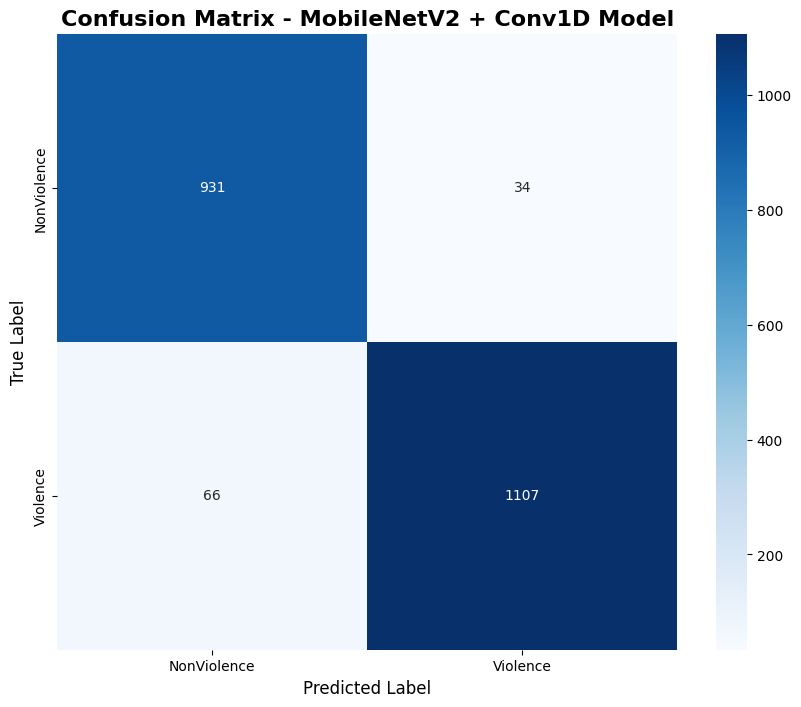


Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.93      0.96      0.95       965
    Violence       0.97      0.94      0.96      1173

    accuracy                           0.95      2138
   macro avg       0.95      0.95      0.95      2138
weighted avg       0.95      0.95      0.95      2138



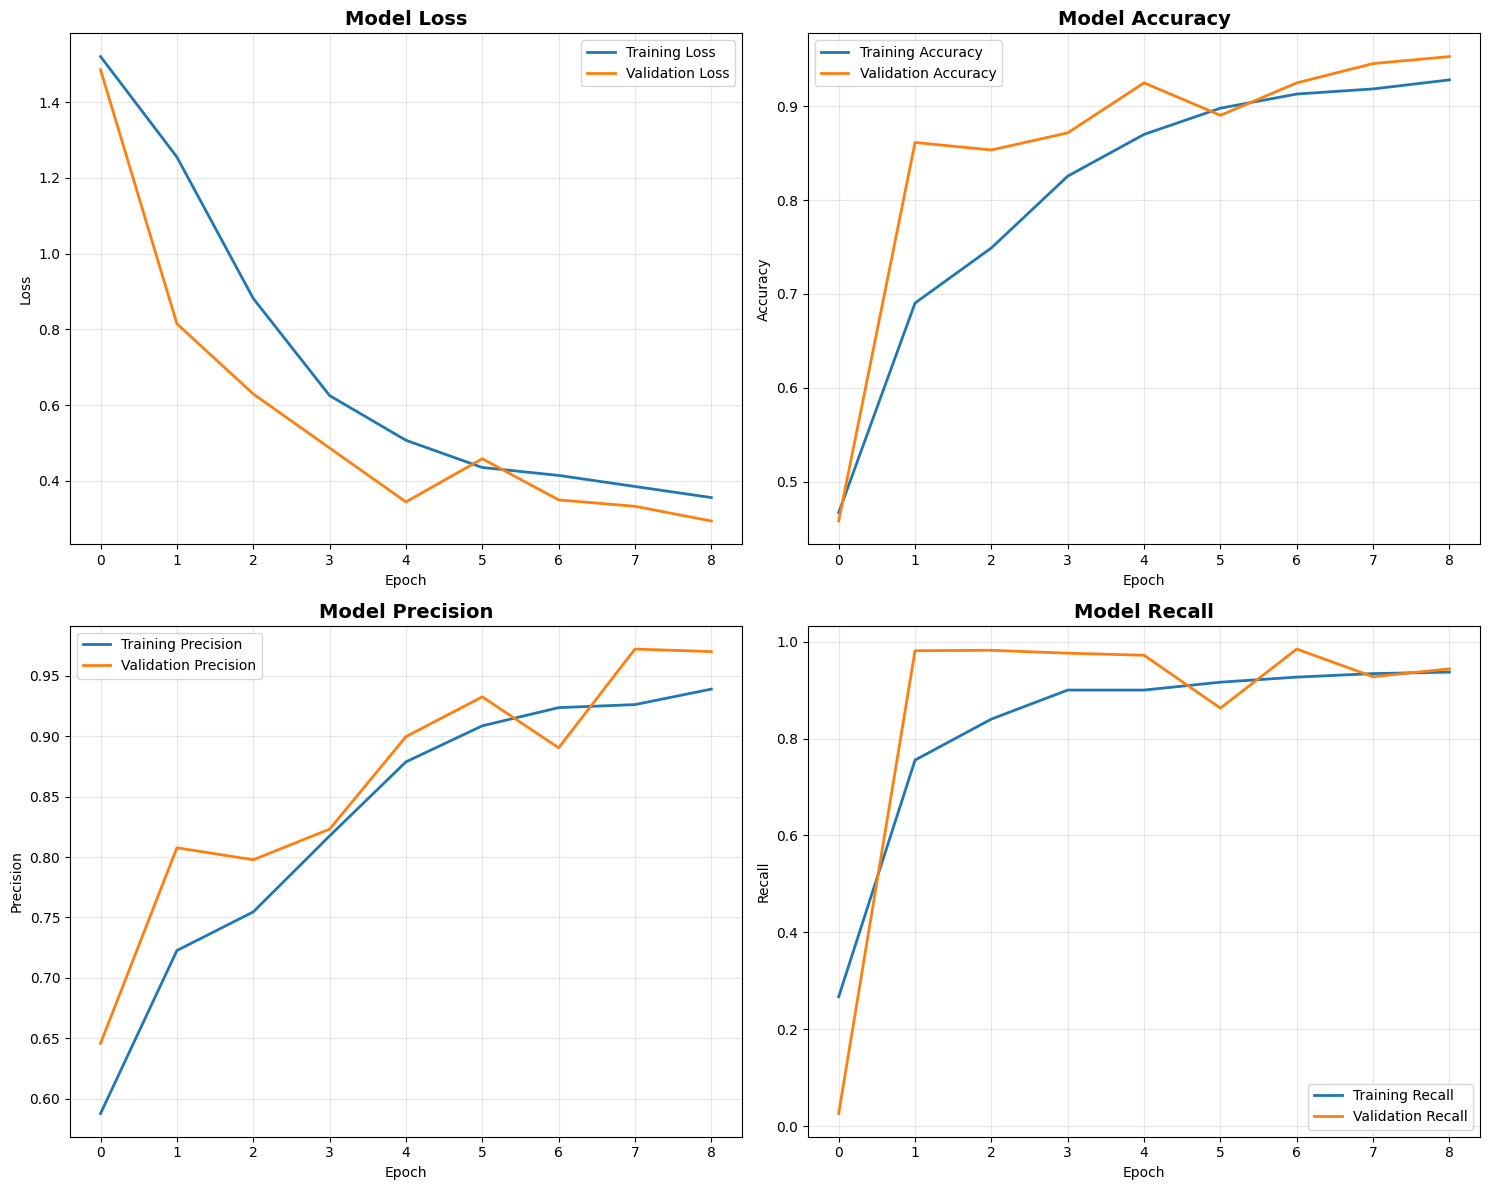

In [45]:
from sklearn import metrics

# Model evaluation

# Print a message indicating the start of model evaluation
print("Evaluating model...")

# Evaluate the model on test data and store metrics (loss, accuracy, precision, recall)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds, verbose=1)

# Print a header for test results
print(f"\nTest Results:")

# Print test loss with 4 decimal places precision
print(f"Loss: {test_loss:.4f}")

# Print test accuracy with 4 decimal places precision
print(f"Accuracy: {test_accuracy:.4f}")

# Print test precision with 4 decimal places precision
print(f"Precision: {test_precision:.4f}")

# Print test recall with 4 decimal places precision
print(f"Recall: {test_recall:.4f}")

# Calculate F1 Score using precision and recall (harmonic mean)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

# Print calculated F1 score with 4 decimal places precision
print(f"F1 Score: {f1_score:.4f}")

# Generate predictions
print("Generating predictions...")

# Get predicted probabilities for test data using specified batch size
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    y_pred_prob = model.predict(x_batch, verbose=0)
    y_pred_bin = (y_pred_prob > 0.5).astype(int)

    y_true.extend(y_batch.numpy().flatten())
    y_pred.extend(y_pred_bin.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


# Create confusion matrix using true labels and predicted labels
cm = metrics.confusion_matrix(y_true, y_pred)

# Create a figure for plotting with specified size (10x8 inches)
plt.figure(figsize=(10, 8))

# Create heatmap visualization of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NonViolence', 'Violence'],
            yticklabels=['NonViolence', 'Violence'])

# Set title for the plot with custom font properties
plt.title('Confusion Matrix - MobileNetV2 + Conv1D Model', fontsize=16, fontweight='bold')

# Set x-axis label with font size
plt.xlabel('Predicted Label', fontsize=12)

# Set y-axis label with font size
plt.ylabel('True Label', fontsize=12)

# Save the confusion matrix plot as PNG image with high DPI and tight bounding box
plt.savefig('images/confusion_matrix_conv1d.png', dpi=300, bbox_inches='tight')

# Display the confusion matrix plot
plt.show()

# Print classification report header
print("\nClassification Report:")

# Print detailed classification report with target class names
print(metrics.classification_report(y_true, y_pred, target_names=['NonViolence', 'Violence']))

# Call custom function to plot training history (accuracy/loss over epochs)
plot_training_history(history)

## Test Prediction on a Sample Video

In [46]:
# Print section header for model loading test
print("\nTesting model loading...")

# Try to load and verify the saved model
try:
    # Attempt to load the model from the specified path
    loaded_model = keras.models.load_model(model_save_path)
    
    # Print success message if loading worked
    print("Model loaded successfully!")
    
    # Perform a quick test prediction if test data exists
    for x_sample, y_sample in test_ds.take(1):
        # Take the first sample from test data & Get model prediction (probability) for the test sample
        prediction = loaded_model.predict(x_sample[:1])[0][0]
        
        # Get actual label for comparison
        actual = y_sample.numpy()[0]
        
        # Print the raw prediction value (formatted to 4 decimal places)
        print(f"Test prediction: {prediction:.4f} (threshold: 0.5)")
        
        # Print the predicted class based on threshold (0.5)
        print(f"Predicted class: {'Violence' if prediction > 0.5 else 'NonViolence'}")
        
        # Print the actual class label for comparison
        print(f"Actual class: {'Violence' if actual == 1 else 'NonViolence'}")
        break

# Handle any exceptions that occur during model loading
except Exception as e:
    # Print error message with details if loading fails
    print(f"Error loading model: {e}")


Testing model loading...


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Test prediction: 0.2583 (threshold: 0.5)
Predicted class: NonViolence
Actual class: NonViolence


In [47]:
# Print completion message with newline for separation
print("\nTraining completed successfully!")

# Display the path where the full model was saved (including architecture and weights)
print(f"Model saved as: {model_save_path}")

# Display the path where the best weights were saved during training
print(f"Best weights saved as: {checkpoint_path}")

# Inform user where to find visualization plots
print("Check the 'images' directory for visualization plots.")

# Inform user where to find training logs for TensorBoard
print("Check the 'logs' directory for TensorBoard logs.")

# Print section header for model architecture summary
print("\n" + "="*50)  # Newline followed by 50 equals signs
print("MODEL ARCHITECTURE SUMMARY")
print("="*50)  # Another separator line

# Display input shape details using constants:
# SEQUENCE_LENGTH (temporal dimension), IMG_SIZE (spatial dimensions), ColorChannels
print(f"Input Shape: ({SEQUENCE_LENGTH}, {IMG_SIZE}, {IMG_SIZE}, {ColorChannels})")

# Indicate the feature extractor used (pretrained MobileNetV2)
print(f"Feature Extractor: MobileNetV2 (ImageNet pretrained)")

# Describe the temporal modeling architecture (3 Conv1D layers with decreasing filters)
print(f"Temporal Modeling: 3-layer Conv1D (256 -> 128 -> 64 filters)")

# List the regularization techniques employed
print(f"Regularization: Dropout, L2 regularization, Batch normalization")

# Display total number of trainable parameters with thousand separators
print(f"Total Parameters: {model.count_params():,}")  # :, adds comma separators

# Print closing separator line
print("="*50)


Training completed successfully!
Model saved as: model/mconv.h5
Best weights saved as: model/conv.weights.h5
Check the 'images' directory for visualization plots.
Check the 'logs' directory for TensorBoard logs.

MODEL ARCHITECTURE SUMMARY
Input Shape: (8, 128, 128, 3)
Feature Extractor: MobileNetV2 (ImageNet pretrained)
Temporal Modeling: 3-layer Conv1D (256 -> 128 -> 64 filters)
Regularization: Dropout, L2 regularization, Batch normalization
Total Parameters: 3,448,833
